In [15]:
# Import libraries
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow_datasets as tfds
import os

# Tuning libraries
from keras_tuner import RandomSearch

In [16]:
# Get data images from 
(ds_train, ds_test), ds_info = tfds.load("mnist", split=["train","test"],shuffle_files=True, as_supervised=True, with_info=True)

# Convert to NumPy arrays
x_train = []
y_train = []

for image, label in tfds.as_numpy(ds_train):
    x_train.append(image)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []

for image, label in tfds.as_numpy(ds_test):
    x_test.append(image)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)


2025-05-07 12:18:00.358448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-07 12:18:00.948165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Axes: ylabel='count'>

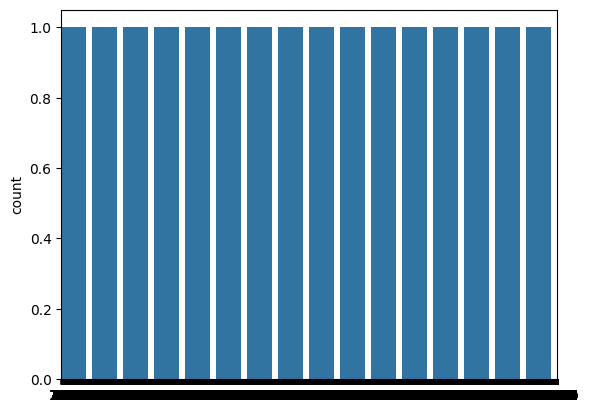

In [32]:
# Plot y train count
sns.countplot(y_train)

In [17]:
# Check for NaN values in training set
np.isnan(x_train).any()

False

In [18]:
# Check for NaN values in test set
np.isnan(x_test).any()

False

In [19]:
# Store all pictures in single tensor:
input_shape = (28,28,1)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], x_train.shape[2],1)
x_train = x_train/255.0
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], x_test.shape[2],1)
x_test = x_test/255.0

In [20]:
# Label encoding: Converting labels to binary values using one_hot function
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test  = tf.one_hot(y_test.astype(np.int32), depth=10)

47040000


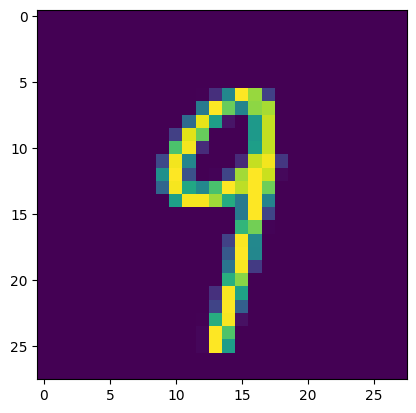

In [21]:
plt.imshow(x_train[400][:,:,0])

In [46]:
# Define model: Start with defining batch size, num_classes and epochs. 
# Num_classes because we are going from 0 to 9 in terms of digit identification
batch_size = 64
num_classes = 10
epochs = 5

In [29]:
# Define model: 
#    Conv2D: Convolutional layers: Each filter (32 in the first 2 conv layers and 64 in the 
#    next two conv layers) transforms a part of the image (5x5 for the first two conv layeyers
#    And 3x3 the for next two convD layers)
#    
def build_model(hp):
    input_shape = (28,28,1)
    num_classes=10
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same',activation='relu',input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same',activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate',1e-4, 1e-2,sampling='log')),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.CategoricalAccuracy()])

    return model

In [33]:
# Fitting the training data:
# Define tuner
tuner = RandomSearch(
    build_model,
    objective='categorical_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory=os.getcwd,
    project_name='batch_epoch_tuning'
)

batch_sizes = [32,64,128]
epoch_options = [5,10,15]

for batch_size in batch_sizes:
    for epochs in epoch_options:
        print(f"\n🔍 Tuning for batch_size={batch_size}, epochs={epochs}")
        tuner.search(x_train, y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(1)[0]
best_model.summary

Trial 10 Complete [00h 37m 05s]
categorical_accuracy: 0.945187509059906

Best categorical_accuracy So Far: 0.9736250042915344
Total elapsed time: 02h 10m 01s

🔍 Tuning for batch_size=32, epochs=10

🔍 Tuning for batch_size=32, epochs=15

🔍 Tuning for batch_size=64, epochs=5

🔍 Tuning for batch_size=64, epochs=10

🔍 Tuning for batch_size=64, epochs=15

🔍 Tuning for batch_size=128, epochs=5

🔍 Tuning for batch_size=128, epochs=10

🔍 Tuning for batch_size=128, epochs=15


/Users/davf/tensorflow-arm/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<bound method Model.summary of <Sequential name=sequential, built=True>>

In [34]:
# Predict results
test_loss, test_acc = best_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - categorical_accuracy: 0.9871 - loss: 0.0657


In [36]:
# Confusion matrix:
# Predict the values from the testing dataset
Y_pred = best_model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Axes: >

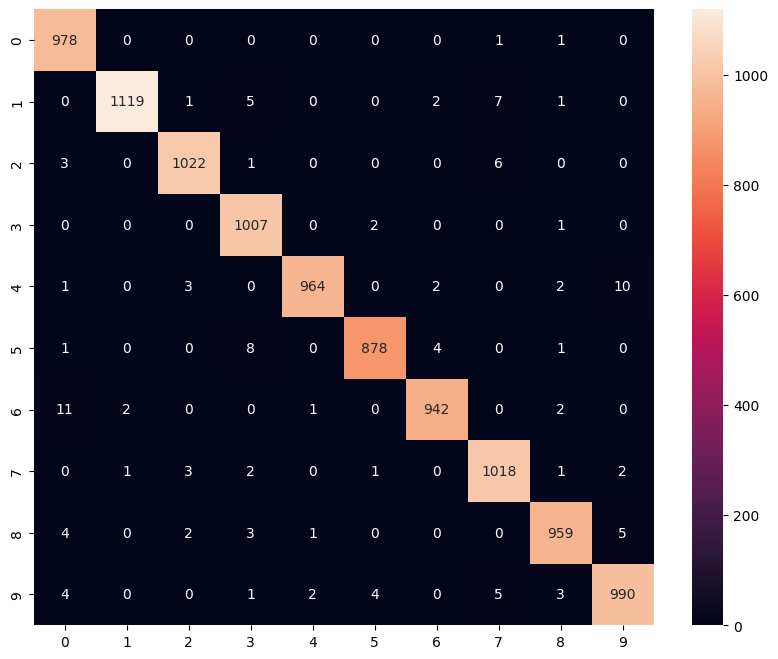

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

In [41]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,714 (1.85 MB)

 Trainable params: 484,714 (1.85 MB)

 Non-trainable params: 0 (0.00 B)